### Importing required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
print("Import Successful")

Import Successful


### Loading data into the dataframe and displaying the last 5 rows

In [3]:
data = pd.read_csv("GOOG.csv", date_parser = True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4199,2021-04-26,2319.929932,2341.260010,2313.840088,2326.739990,2326.739990,1041700
4200,2021-04-27,2336.000000,2337.449951,2304.270020,2307.120117,2307.120117,1598600
4201,2021-04-28,2407.145020,2452.377930,2374.850098,2379.909912,2379.909912,2986400
4202,2021-04-29,2410.330078,2436.520020,2402.280029,2429.889893,2429.889893,1977700
4203,2021-04-30,2404.489990,2427.139893,2402.159912,2410.120117,2410.120117,1956700


### Splitting into Training and Testing Data
##### All data till 31st December 2020 is included in Training data and the one after that is taken for testing purpose

In [5]:
data_training = data[data["Date"]<"2021-01-01"].copy()
data_test = data[data["Date"]>="2021-01-01"].copy()

##### Dropping the Date and Adj Close columns as they aren't relevant

In [6]:
data_training = data_training.drop(["Date", "Adj Close"], axis = 1)

### Normalizing the Training Data
##### Since the training data is not in the same range, we are going to use MinMaxScaler() to get it in the range of 0 to 1

In [7]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
data_training

array([[2.27303632e-04, 6.43283156e-04, 0.00000000e+00, 9.24472018e-05,
        5.43577158e-01],
       [5.10729413e-04, 2.03521039e-03, 1.27420629e-03, 2.32514214e-03,
        2.77885876e-01],
       [3.24397659e-03, 3.25522693e-03, 3.67386538e-03, 2.63049229e-03,
        2.22151352e-01],
       ...,
       [9.79308338e-01, 9.69518841e-01, 9.62498190e-01, 9.61044247e-01,
        1.56478852e-02],
       [9.64785280e-01, 9.54297762e-01, 9.45319271e-01, 9.50246667e-01,
        1.57290641e-02],
       [9.49805947e-01, 9.50866174e-01, 9.50852174e-01, 9.57197618e-01,
        1.21644600e-02]])

#### We'll be training the model on data of 60 days at a time , so we'll divide the data into chunks of 60 rows reach
##### 4062 is the length of training data

In [8]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train.shape

(4062, 60, 5)

### Building LSTM

#### Importing necessary layers to build the neural network

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
print("Import Success!")

Import Success!


##### The first layer is the LSTM layer with 60 units.
##### We will be using relu activation function.
##### The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.relu.png
##### return_sequence when set to True returns the full sequence as the output.
##### input_shape is set to (X_train.shape[1],5) which is (60,5)
##### Dropout layer is used to by randomly set the outgoing edges of hidden units to 0 at each update of the training phase.
##### The value passed in dropout specifies the probability at which outputs of the layer are dropped out.
##### The last layer is the Dense layer is the regular deeply connected neural network layer.
##### As we are predicting a single value the units in the last layer is set to 1.

In [12]:
regressor = Sequential()

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [13]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            15840     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

### We are going to compile the model and fit it to the training dataset now
#### We'll be using 50 epochs. An epoch is an iteration over the datatset.

In [14]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
127/127 [==============================] - 37s 169ms/step - loss: 0.0127
Epoch 2/50
127/127 [==============================] - 19s 151ms/step - loss: 0.0019
Epoch 3/50
127/127 [==============================] - 21s 162ms/step - loss: 0.0016
Epoch 4/50
127/127 [==============================] - 21s 164ms/step - loss: 0.0016
Epoch 5/50
127/127 [==============================] - 21s 165ms/step - loss: 0.0014
Epoch 6/50
127/127 [==============================] - 20s 154ms/step - loss: 0.0015
Epoch 7/50
127/127 [==============================] - 20s 155ms/step - loss: 0.0013
Epoch 8/50
127/127 [==============================] - 18s 139ms/step - loss: 0.0011
Epoch 9/50
127/127 [==============================] - 18s 139ms/step - loss: 0.0012
Epoch 10/50
127/127 [==============================] - 18s 140ms/step - loss: 0.0011
Epoch 11/50
127/127 [==============================] - 18s 139ms/step - loss: 9.6082e-04
Epoch 12/50
127/127 [==============================] - 18s 139ms/step 

### Preparing Test Dataset

In [15]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
4122,2021-01-04,1757.540039,1760.650024,1707.849976,1728.239990,1728.239990,1901900
4123,2021-01-05,1725.000000,1747.670044,1718.015015,1740.920044,1740.920044,1145300
4124,2021-01-06,1702.630005,1748.000000,1699.000000,1735.290039,1735.290039,2602100
4125,2021-01-07,1740.060059,1788.400024,1737.050049,1787.250000,1787.250000,2265000
4126,2021-01-08,1787.979980,1809.839966,1773.535034,1807.209961,1807.209961,2050600


In [16]:
past_60_days = data_test.tail(60)

#### We are going to append data_set to past_60_days and drop the Date and Adj Close columns

In [17]:
df = past_60_days.append(data_test, ignore_index = True)
df = df.drop(["Date", "Adj Close"], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,2068.889893,2078.550049,2042.589966,2062.370117,1852300
1,2070.000000,2102.510010,2059.330078,2098.000000,1533900
2,2105.909912,2123.547119,2072.000000,2092.909912,1241900
3,2078.540039,2105.129883,2078.540039,2083.510010,889900
4,2094.209961,2108.370117,2063.090088,2095.379883,1135500


##### Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.

In [18]:
inputs = scaler.transform(df)
inputs

array([[1.13766462, 1.12877681, 1.12392035, 1.13180961, 0.02234697],
       [1.13828999, 1.14211368, 1.13335221, 1.15184698, 0.01848915],
       [1.15851967, 1.1538236 , 1.1404908 , 1.14898444, 0.0149512 ],
       [1.14310098, 1.14357199, 1.14417564, 1.14369817, 0.01068628],
       [1.15192856, 1.1453756 , 1.1354707 , 1.15037349, 0.01366203],
       [1.15491432, 1.14184651, 1.14348827, 1.15066031, 0.01135631],
       [1.14969774, 1.14562606, 1.14676169, 1.15528316, 0.0102719 ],
       [1.1576466 , 1.17003985, 1.15872339, 1.1652877 , 0.01364143],
       [1.15519035, 1.15945271, 1.15565824, 1.16889261, 0.01287932],
       [1.16104345, 1.15893793, 1.15835708, 1.16264456, 0.01349361],
       [1.16604603, 1.15771051, 1.15480746, 1.15361278, 0.01756225],
       [1.13659996, 1.13594059, 1.13493533, 1.13322104, 0.016473  ],
       [1.11294509, 1.13070273, 1.10106211, 1.13658417, 0.02010667],
       [1.12242053, 1.14115072, 1.12140749, 1.15025542, 0.01502874],
       [1.13685344, 1.13786651, 1.

#### Preparing test dataset just like we did for the training dataset i.e. chunks of 60 rows

In [19]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((82, 60, 5), (82,))

#### We are now going to predict the opening for X_test using predict()

In [20]:
y_pred = regressor.predict(X_test)
scaler.scale_

array([5.63345301e-04, 5.56631737e-04, 5.63428151e-04, 5.62375381e-04,
       1.21162615e-08])

#### As we had scaled all the values down, now we will have to get them back to the original scale. scaler.scale_ gives the scaling level

#### 8.186 is the first value in the list which gives the scale of opening price. We will multiply y_pred and y_test with the inverse of this to get all the values to the original scale.

In [21]:
scale = 1/8.18605127e-04
scale

1221.5901990069017

In [22]:
y_pred = y_pred*scale
y_test = y_test*scale

### Visualising the results

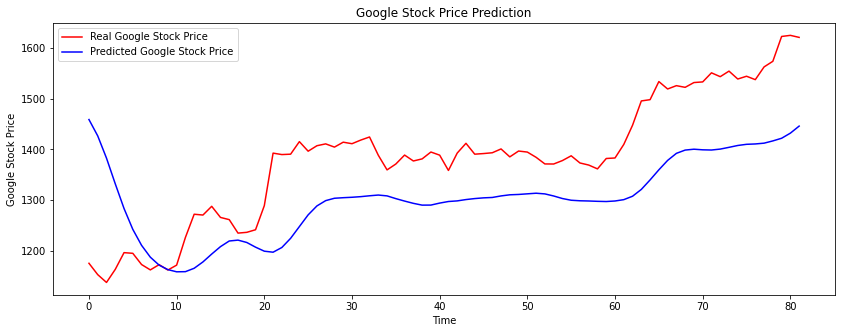

In [23]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()